# Imports & loading

In [1]:
from support import load_dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from tqdm.notebook import tqdm 

import pandas as pd

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
)
import plotly

In [2]:
import torch, gc, os

def get_device():
    if torch.backends.mps.is_available():         # Apple GPU
        return torch.device("mps")
    elif torch.cuda.is_available():               # NVIDIA eGPU etc.
        return torch.device("cuda")
    else:                                         # fallback
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.set_float32_matmul_precision("high")        # speeds M-series matmul
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"   # CPU fallback for missing ops


Using device: mps


#### Print Python and PyTorch version

In [3]:
print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python version: 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
PyTorch version: 2.7.0
CUDA available: False


In [4]:
data = load_dataset()
train_dataset = data[0]
test_dataset = data[1]

In [5]:
img, label = train_dataset[0]

print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Train_dataset: {train_dataset}")

Image shape: torch.Size([3, 60, 30])
Label: 0
Train_dataset: Dataset ImageFolder
    Number of datapoints: 136
    Root location: WF-data/train
    StandardTransform
Transform: Compose(
               Resize(size=[105, 78], interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=[60, 30])
               ToTensor()
           )


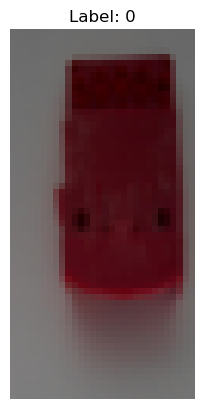

In [6]:
img_tensor, label = train_dataset[0]
transform_to_pil = T.ToPILImage()
img_pil = transform_to_pil(img_tensor)

plt.imshow(img_pil)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Base model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes,
                 conv1_out_channels=16, conv2_out_channels=32, fc_neurons=128):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, conv1_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: conv1_out_channels x H/2 x W/2
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: conv2_out_channels x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters (Base Model)
learning_rate = 0.001
batch_size = 16 
num_epochs = 25 
num_classes = 2 

# Default architectural parameters for the base model
conv1_out_channels_base = 16
conv2_out_channels_base = 32
fc_neurons_base = 128

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Use the (potentially modified) SimpleCNN class
model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes,
                    conv1_out_channels=conv1_out_channels_base, 
                    conv2_out_channels=conv2_out_channels_base, 
                    fc_neurons=fc_neurons_base).to(device)
# model = torch.compile(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store metrics for plotting
epoch_train_losses = []
epoch_test_accuracies = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1) 

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch
    
    avg_epoch_loss = running_loss / len(train_loader.dataset)  # Average loss over the entire training set
    epoch_train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    epoch_test_accuracies.append(accuracy)
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect()                        # reclaim Python-held objects

print("Finished Training Base Model")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30] completed. Average Training Loss: 0.6981
Accuracy on test set after epoch 1: 70.59%
Epoch [2/30] completed. Average Training Loss: 0.6971
Accuracy on test set after epoch 2: 50.00%
Epoch [3/30] completed. Average Training Loss: 0.6942
Accuracy on test set after epoch 3: 50.00%
Epoch [4/30] completed. Average Training Loss: 0.6931
Accuracy on test set after epoch 4: 50.00%
Epoch [5/30] completed. Average Training Loss: 0.6916
Accuracy on test set after epoch 5: 50.00%
Epoch [6/30] completed. Average Training Loss: 0.6890
Accuracy on test set after epoch 6: 76.47%
Epoch [7/30] completed. Average Training Loss: 0.6828
Accuracy on test set after epoch 7: 50.00%
Epoch [8/30] completed. Average Training Loss: 0.6754
Accuracy on test set after epoch 8: 76.47%


### Plots

ValueError: x and y must have same first dimension, but have shapes (40,) and (10,)

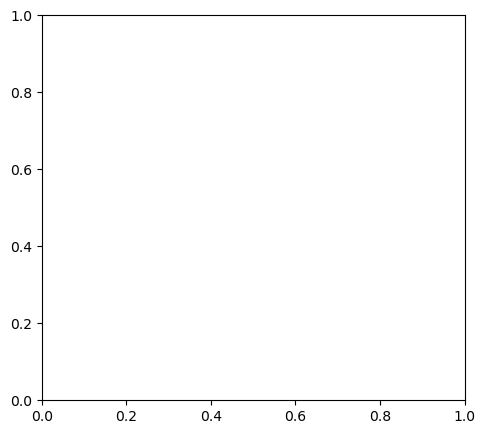

In [ ]:
# Plotting learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter tuning

### Random Search

Using device for hyperparameter tuning: mps


Hyperparameter Search Trials:   0%|          | 0/3 [00:00<?, ?trial/s]


Trial 1/3 - Testing params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 32, 'fc_neurons': 256}
  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/3 [00:00<?, ?it/s]

  Trial 1 Avg CV Accuracy: 55.11%
  New best average CV accuracy: 55.11% with params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 32, 'fc_neurons': 256}

Trial 2/3 - Testing params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc_neurons': 256}
  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/3 [00:00<?, ?it/s]

  Trial 2 Avg CV Accuracy: 46.35%

Trial 3/3 - Testing params: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 64}
  Fold 1/5


    Epochs (Fold 1):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 2/5


    Epochs (Fold 2):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 3/5


    Epochs (Fold 3):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 4/5


    Epochs (Fold 4):   0%|          | 0/3 [00:00<?, ?it/s]

  Fold 5/5


    Epochs (Fold 5):   0%|          | 0/3 [00:00<?, ?it/s]

  Trial 3 Avg CV Accuracy: 55.21%
  New best average CV accuracy: 55.21% with params: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 64}

Finished Hyperparameter Search.


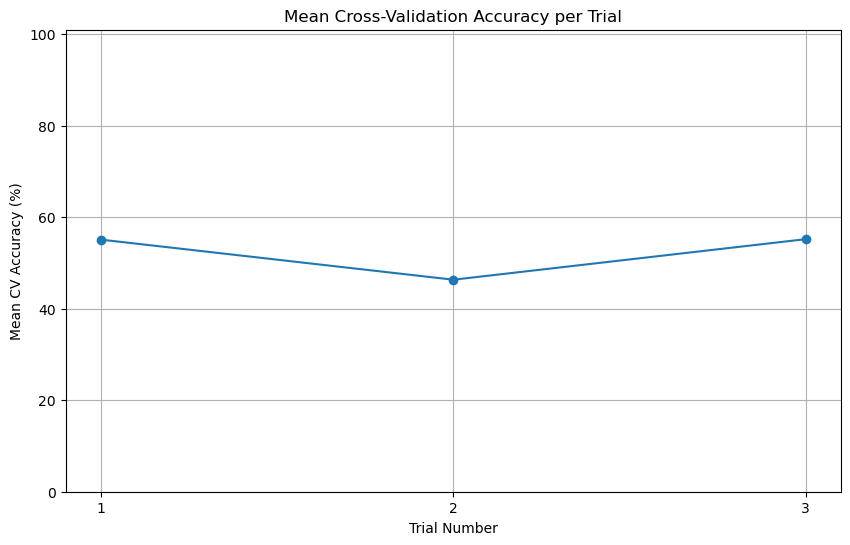

In [ ]:
device = get_device()
print(f"Using device for hyperparameter tuning: {device}")
 
# Get image dimensions (C, H, W should be available from the previous cell or re-derived)
if 'C' not in locals() or 'H' not in locals() or 'W' not in locals():
    sample_img, _ = train_dataset[0]
    C, H, W = sample_img.shape
    print(f"Re-detected image shape: Channels={C}, Height={H}, Width={W}")
 
# Import KFold
from sklearn.model_selection import KFold
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported for trial plots
 
# Hyperparameter search space
param_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'batch_size': [8, 16, 32],
    'conv1_out_channels': [8, 16, 32],
    'conv2_out_channels': [16, 32, 64],
    'fc_neurons': [64, 128, 256],
}
 
# Store history for the best model's learning curves
best_model_train_losses = []
best_model_val_accuracies = []
 
num_classes_hp = 2
num_epochs_search = 25 # Epochs for each fold in CV and for final retraining
num_trials = 10 # Number of random hyperparameter sets to try
n_splits_cv = 5 # Number of folds for cross-validation
 
best_hyperparams = None
best_avg_cv_accuracy = -1.0
# These will store learning curves for the FINAL retrained model
final_retrained_model_train_losses = []
final_retrained_model_test_accuracies = [] # Using test set for the final model's curve
 
perfect_found = False # If average CV accuracy hits 100%
 
all_trials_final_cv_accuracies = [] # To store final avg CV accuracy for each trial
 
for trial in tqdm(range(num_trials), desc="Hyperparameter Search Trials", unit="trial", leave=True):
    if perfect_found:
        print("Perfect hyperparameters found based on CV, stopping further trials.")
        break
 
    current_params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"\nTrial {trial+1}/{num_trials} - Testing params: {current_params}")
 
    kf = KFold(n_splits=n_splits_cv, shuffle=True, random_state=trial)
   
    trial_fold_final_accuracies = []
    # Store epoch-wise validation accuracies for each fold, to average later for plotting
    # This is still useful if you want to debug or see per-fold performance, but not for the requested final plot
    trial_all_folds_epoch_val_accuracies = [[] for _ in range(num_epochs_search)]
 
    pin_memory_flag = device.type == 'cuda'
    num_workers_flag = 2 if device.type == 'cuda' else 0
 
    for fold_idx, (train_ids, val_ids) in enumerate(tqdm(kf.split(train_dataset), total=n_splits_cv, desc="CV Folds", leave=True)):        
    # for fold_idx, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
        print(f"  Fold {fold_idx+1}/{n_splits_cv}")
       
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
 
        try:
            current_train_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], sampler=train_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
            current_val_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], sampler=val_subsampler, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        except Exception as e:
            print(f"  Error creating DataLoader for fold {fold_idx+1}, possibly due to batch size: {e}. Skipping fold.")
            trial_fold_final_accuracies.append(0)
            for epoch_list_idx in range(num_epochs_search):
                 if len(trial_all_folds_epoch_val_accuracies[epoch_list_idx]) == fold_idx :
                     trial_all_folds_epoch_val_accuracies[epoch_list_idx].append(0)
            continue
           
        model_hp = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                                conv1_out_channels=current_params['conv1_out_channels'],
                                conv2_out_channels=current_params['conv2_out_channels'],
                                fc_neurons=current_params['fc_neurons']).to(device)
       
        criterion_hp = nn.BCEWithLogitsLoss()
        optimizer_hp = optim.Adam(model_hp.parameters(), lr=current_params['learning_rate'])
 
        fold_epoch_val_accuracies = []
 
        for epoch in tqdm(range(num_epochs_search), desc=f"    Epochs (Fold {fold_idx+1})", leave=True):
            model_hp.train()
            # ... (training loop for the fold) ...
            epoch_running_loss = 0.0
            for images, labels in current_train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer_hp.zero_grad()
                outputs = model_hp(images)
                loss = criterion_hp(outputs, labels)
                loss.backward()
                optimizer_hp.step()
                epoch_running_loss += loss.item() * images.size(0)
 
            model_hp.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for images, labels in current_val_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    outputs = model_hp(images)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
           
            current_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0.0
            fold_epoch_val_accuracies.append(current_epoch_val_accuracy)
            trial_all_folds_epoch_val_accuracies[epoch].append(current_epoch_val_accuracy)
 
            if device.type == "mps": torch.mps.empty_cache()
            elif device.type == "cuda": torch.cuda.empty_cache()
            gc.collect()
       
        trial_fold_final_accuracies.append(fold_epoch_val_accuracies[-1] if fold_epoch_val_accuracies else 0.0)
        del model_hp, optimizer_hp, criterion_hp, current_train_loader, current_val_loader
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    current_trial_avg_final_cv_accuracy = np.mean(trial_fold_final_accuracies) if trial_fold_final_accuracies else 0.0
    all_trials_final_cv_accuracies.append(current_trial_avg_final_cv_accuracy) # Store for the final plot
    print(f"  Trial {trial+1} Avg CV Accuracy: {current_trial_avg_final_cv_accuracy:.2f}%")
 
    if current_trial_avg_final_cv_accuracy > best_avg_cv_accuracy:
        best_avg_cv_accuracy = current_trial_avg_final_cv_accuracy
        best_hyperparams = current_params
        print(f"  New best average CV accuracy: {best_avg_cv_accuracy:.2f}% with params: {best_hyperparams}")
 
    if best_avg_cv_accuracy == 100.0:
        perfect_found = True
       
print("\nFinished Hyperparameter Search.")
 
# Plot Mean CV Accuracy per Trial
if all_trials_final_cv_accuracies:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(all_trials_final_cv_accuracies) + 1), all_trials_final_cv_accuracies, marker='o', linestyle='-')
    plt.title("Mean Cross-Validation Accuracy per Trial")
    plt.xlabel("Trial Number")
    plt.ylabel("Mean CV Accuracy (%)")
    plt.xticks(range(1, len(all_trials_final_cv_accuracies) + 1))
    plt.grid(True)
    plt.ylim(0, 101)
    plt.show()
 

In [ ]:
best_model_train_losses = []
best_model_val_accuracies = []
best_model_train_accuracies = [] # New list for training accuracies
 
if best_hyperparams:
    print(f"Best hyperparameters found: {best_hyperparams}")
    print(f"Best average CV validation accuracy: {best_avg_cv_accuracy:.2f}%")
 
    # Retrain the model on the full training dataset with the best hyperparameters
    print("\nRetraining model with best hyperparameters on the full training dataset...")
   
    final_train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    final_test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
 
    final_model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                            conv1_out_channels=best_hyperparams['conv1_out_channels'],
                            conv2_out_channels=best_hyperparams['conv2_out_channels'],
                            fc_neurons=best_hyperparams['fc_neurons']).to(device)
   
    criterion_final = nn.BCEWithLogitsLoss()
    optimizer_final = optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])
 
    best_model_train_losses.clear()
    best_model_val_accuracies.clear()
    best_model_train_accuracies.clear() # Clear training accuracies list
 
    for epoch in tqdm(range(num_epochs_search), desc="Final Model Retraining", unit="epoch"):
        final_model.train()
        running_loss = 0.0
        for images, labels in final_train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_final.zero_grad()
            outputs = final_model(images)
            loss = criterion_final(outputs, labels)
            loss.backward()
            optimizer_final.step()
            running_loss += loss.item() * images.size(0)
       
        avg_epoch_loss = running_loss / len(final_train_loader.dataset)
        best_model_train_losses.append(avg_epoch_loss)
 
        # Evaluate on the training set for training accuracy
        final_model.eval()
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for images_train, labels_train in final_train_loader:
                images_train, labels_train = images_train.to(device), labels_train.to(device).float().unsqueeze(1)
                outputs_train = final_model(images_train)
                predicted_train = (torch.sigmoid(outputs_train) > 0.5).float()
                train_total += labels_train.size(0)
                train_correct += (predicted_train == labels_train).sum().item()
        current_train_accuracy = 100 * train_correct / train_total if train_total > 0 else 0.0
        best_model_train_accuracies.append(current_train_accuracy)
 
        # Evaluate on the test set for test accuracy
        # final_model.eval() # Already in eval mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in final_test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = final_model(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
       
        accuracy = 100 * correct / total if total > 0 else 0.0
        best_model_val_accuracies.append(accuracy)
        print(f"  Epoch {epoch+1}/{num_epochs_search} - Train Loss: {avg_epoch_loss:.4f}, Train Acc: {current_train_accuracy:.2f}%, Test Acc: {accuracy:.2f}%")
 
        if device.type == "mps": torch.mps.empty_cache()
        elif device.type == "cuda": torch.cuda.empty_cache()
        gc.collect()
 
    best_randomsearch_model_path = "best_randomsearch_cnn_model.pth"
    torch.save(final_model.state_dict(), best_randomsearch_model_path)
    print(f"Best retrained model saved to {best_randomsearch_model_path}")
 
else:
    print("No best hyperparameters found (e.g., all trials failed or num_trials was 0).")
    best_model_train_losses = []
    best_model_val_accuracies = []
    best_model_train_accuracies = [] 
 

Best hyperparameters found: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 64}
Best average CV validation accuracy: 55.21%

Retraining model with best hyperparameters on the full training dataset...


Final Model Retraining:   0%|          | 0/3 [00:00<?, ?epoch/s]

  Epoch 1/3 - Train Loss: 0.7109, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 2/3 - Train Loss: 0.6947, Train Acc: 50.00%, Test Acc: 50.00%
  Epoch 3/3 - Train Loss: 0.6941, Train Acc: 50.00%, Test Acc: 50.00%
Best retrained model saved to best_randomsearch_cnn_model.pth


#### Plots

Best Average CV Accuracy (from Hyperparameter Search): 55.21%
Best Hyperparameters (from Hyperparameter Search): {'learning_rate': 0.001, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 64}
Final Retrained Model Train Accuracy: 50.00%
Final Retrained Model Test Accuracy: 50.00%
Number of epochs for retraining: 3


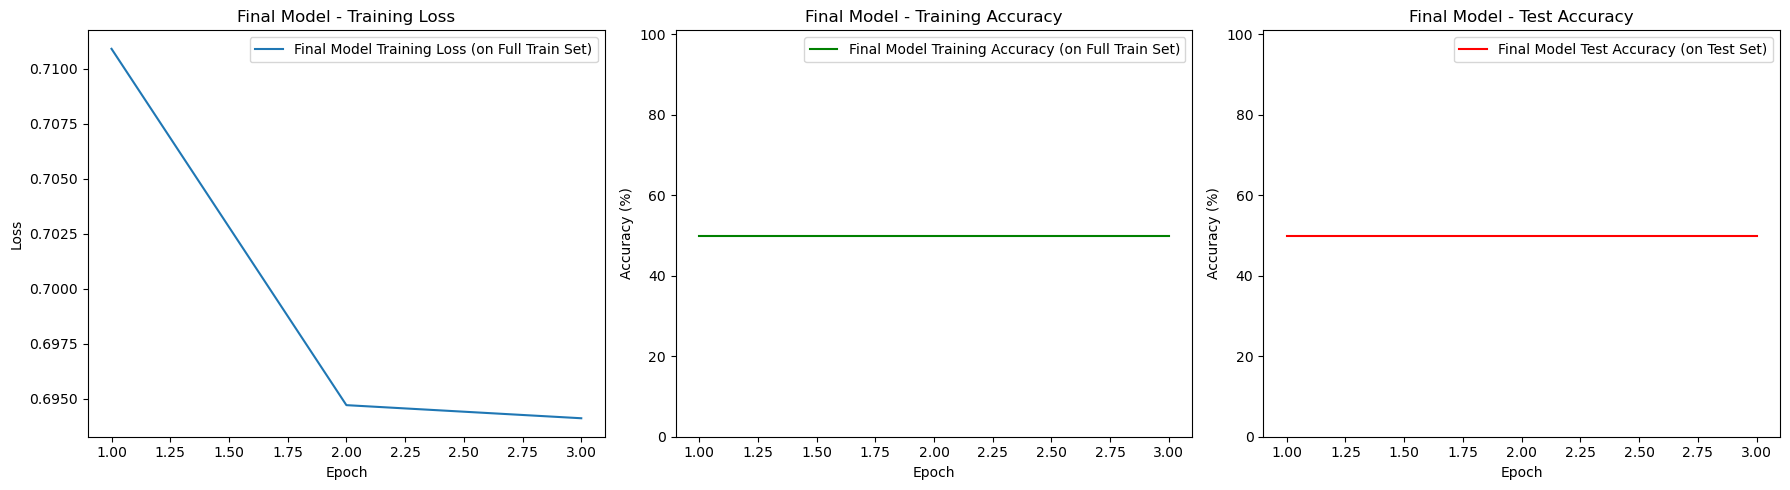

In [ ]:
epochs = list(range(1, len(best_model_train_losses) + 1))
 
# best_avg_cv_accuracy is from the hyperparameter search phase
print(f"Best Average CV Accuracy (from Hyperparameter Search): {best_avg_cv_accuracy:.2f}%")
print(f"Best Hyperparameters (from Hyperparameter Search): {best_hyperparams}")
 
if epochs:
    # best_model_val_accuracies now contains test accuracies of the retrained model
    final_model_test_accuracy = best_model_val_accuracies[-1] # Get the last epoch's test accuracy
    if best_model_train_accuracies:
        final_model_train_accuracy = best_model_train_accuracies[-1]
        print(f"Final Retrained Model Train Accuracy: {final_model_train_accuracy:.2f}%")
    print(f"Final Retrained Model Test Accuracy: {final_model_test_accuracy:.2f}%")
    print(f"Number of epochs for retraining: {len(epochs)}")
else:
    print("No retraining was performed or data is missing for plotting.")
 
 
# Plotting learning curves for the best model from hyperparameter search
# These curves are from the model retrained on the full training set and evaluated on the test set.
if best_model_train_losses and best_model_val_accuracies and best_model_train_accuracies:
    plt.figure(figsize=(18, 5)) # Adjusted figure size for three subplots
 
    plt.subplot(1, 3, 1)
    plt.plot(epochs, best_model_train_losses, label='RS Model Training Loss (on Full Train Set)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Model - Training Loss')
    plt.legend()
 
    plt.subplot(1, 3, 2) # New subplot for Training Accuracy
    plt.plot(epochs, best_model_train_accuracies, label='RS Model Training Accuracy (on Full Train Set)', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Training Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.subplot(1, 3, 3) # Adjusted subplot index for Test Accuracy
    plt.plot(epochs, best_model_val_accuracies, label='RS Model Test Accuracy (on Test Set)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model - Test Accuracy')
    plt.legend()
    plt.ylim(0, 101) # Optional: Set y-axis limits for accuracy
 
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final retrained model is not available or incomplete.")
 

### Method 2 - Optuna

In [ ]:
# Device configuration
device = get_device()
print(f"Using device for Optuna hyperparameter tuning: {device}")

# Get image dimensions
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Image shape: Channels={C}, Height={H}, Width={W}")

num_classes_hp = 2
num_epochs_search = 40 # Fewer epochs for faster search, adjust as needed for Optuna trials
num_trials_optuna = 10 # Define number of trials

def stop_when_perfect(study, trial):
    if trial.value is not None and trial.value >= 100.0:
        study.stop()

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    conv1_out = trial.suggest_categorical("conv1_out_channels", [8, 16, 32, 64])
    conv2_out = trial.suggest_categorical("conv2_out_channels", [16, 32, 64, 128])
    fc_neurons_val = trial.suggest_categorical("fc_neurons", [64, 128, 256])

    # DataLoaders
    pin_memory_flag   = device.type == 'cuda'
    num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

    try:
        current_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        current_val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    except Exception as e:
        print(f"Error creating DataLoader for trial {trial.number}: {e}. Pruning trial.")
        raise optuna.exceptions.TrialPruned()


    # Model (Ensure SimpleCNN class is defined and accessible)
    model_opt = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                          conv1_out_channels=conv1_out,
                          conv2_out_channels=conv2_out,
                          fc_neurons=fc_neurons_val).to(device)

    criterion_opt = nn.BCEWithLogitsLoss()
    optimizer_opt = optim.Adam(model_opt.parameters(), lr=lr)

    trial_train_losses = []
    trial_val_accuracies = []

    patience = 10
    best_val_acc = 0.0
    epochs_no_improve = 0

    # Training loop
    for epoch in tqdm(range(num_epochs_search), desc=f"Trial {trial.number} [Training]", leave=True):
        model_opt.train()
        epoch_running_loss = 0.0
        for images, labels in current_train_loader: # train_pbar_opt:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer_opt.zero_grad(set_to_none=True)
            loss = criterion_opt(model_opt(images), labels)
            loss.backward()
            optimizer_opt.step()

            epoch_running_loss += loss.item() * images.size(0)

        trial_train_losses.append(epoch_running_loss / len(train_loader.dataset))

        # Validation
        model_opt.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in current_val_loader: # val_pbar_opt:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model_opt(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        current_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0
        trial_val_accuracies.append(current_epoch_val_accuracy)
        
        if current_epoch_val_accuracy > best_val_acc:
            best_val_acc = current_epoch_val_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} for trial {trial.number}. No improvement in validation accuracy for {patience} epochs.")
            break

        if current_epoch_val_accuracy == 100.0:
            print(f"Perfect validation accuracy reached at epoch {epoch+1} for trial {trial.number}. Stopping early.")
            break

        # Optuna pruning (optional, but good for long searches)
        trial.report(current_epoch_val_accuracy, epoch)
        if trial.should_prune():
            # Store partial curves if pruned
            trial.set_user_attr("train_losses", trial_train_losses)
            trial.set_user_attr("val_accuracies", trial_val_accuracies)
            raise optuna.exceptions.TrialPruned()

    # Store full learning curves in user attributes for the trial
    trial.set_user_attr("train_losses", trial_train_losses)
    trial.set_user_attr("val_accuracies", trial_val_accuracies)

    del model_opt, optimizer_opt, criterion_opt, current_train_loader, current_val_loader  
    if device.type == "mps":                                   
        torch.mps.empty_cache()
    elif device.type == "cuda":                                
        torch.cuda.empty_cache()
    gc.collect()   

    return best_val_acc
    # return trial_val_accuracies[-1] # Return final validation accuracy

# Create a study object and optimize
# You can add a pruner, e.g., optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_min_trials=3, n_warmup_steps=3))
# study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True)
study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True, callbacks=[stop_when_perfect], show_progress_bar=True)


print("\nFinished Optuna Hyperparameter Search.")
best_trial_optuna = study.best_trial
best_hyperparams_optuna = best_trial_optuna.params
best_val_accuracy_optuna = best_trial_optuna.value


# Retrieve learning curves for the best trial
best_model_train_losses_optuna = best_trial_optuna.user_attrs.get("train_losses", [])
best_model_val_accuracies_optuna = best_trial_optuna.user_attrs.get("val_accuracies", [])

In [ ]:
fig1 = plot_optimization_history(study)
fig1.show()  # in Jupyter this will render an interactive Plotly chart


In [ ]:
fig2 = plot_param_importances(study)
fig2.show()


In [ ]:
fig3 = plot_parallel_coordinate(study)
fig3.show()


In [ ]:
fig4 = plot_slice(study, params=["learning_rate", "batch_size", "conv1_out_channels"])
fig4.show()

In [ ]:
fig5 = plot_contour(study, params=["learning_rate", "batch_size"])
fig5.show()

In [ ]:
train_losses = best_trial_optuna.user_attrs.get("train_losses", [])
val_accs     = best_trial_optuna.user_attrs.get("val_accuracies", [])

df = pd.DataFrame({
    "epoch": list(range(1, len(train_losses) + 1)),
    "train_loss": train_losses,
    "val_accuracy": val_accs,
})
df.to_csv("best_trial_curves.csv", index=False)
# df

## Retrain best optuna model

In [ ]:
# # After Optuna optimization, retrain the best model with the best hyperparameters and save it

# # Extract best hyperparameters from the Optuna study
# best_params = study.best_trial.params

# # Dataloaders with the best batch size
# pin_memory_flag   = device.type == 'cuda'
# num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

# train_loader_opt = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
# val_loader_opt = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# # Re-create and train the model with the best hyperparameters
# model_optimal = SimpleCNN(
#     input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
#     conv1_out_channels=best_params['conv1_out_channels'],
#     conv2_out_channels=best_params['conv2_out_channels'],
#     fc_neurons=best_params['fc_neurons']
# ).to(device)

# criterion_opt = nn.BCEWithLogitsLoss()
# optimizer_opt = optim.Adam(model_optimal.parameters(), lr=best_params['learning_rate'])
# num_epochs_opt = num_epochs_search  # Or set to a higher value for final training

# for epoch in tqdm(range(num_epochs_opt), desc=f"Epoch {trial+1} Training", leave=True):
# # for epoch in range(num_epochs_opt):
#     model_optimal.train()
#     for images, labels in train_loader_opt:
#         images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
#         optimizer_opt.zero_grad()
#         outputs = model_optimal(images)
#         loss = criterion_opt(outputs, labels)
#         loss.backward()
#         optimizer_opt.step()

# # Save the trained optimal model
# best_optuna_model_path = "best_optuna_cnn_model.pth"
# torch.save(model_optimal.state_dict(), best_optuna_model_path)
# print(f"Optimal model saved to {best_optuna_model_path}")


In [ ]:
# After Optuna optimization, retrain the best model with the best hyperparameters and save it

# Extract best hyperparameters from the Optuna study
best_params = study.best_trial.params

# Dataloaders with the best batch size
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

train_loader_opt = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
val_loader_opt = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Re-create and train the model with the best hyperparameters
model_optimal = SimpleCNN(
    input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
    conv1_out_channels=best_params['conv1_out_channels'],
    conv2_out_channels=best_params['conv2_out_channels'],
    fc_neurons=best_params['fc_neurons']
).to(device)

criterion_opt = nn.BCEWithLogitsLoss()
optimizer_opt = optim.Adam(model_optimal.parameters(), lr=best_params['learning_rate'])
num_epochs_opt = num_epochs_search  # Or set to a higher value for final training

best_model_train_losses_optuna = []
best_model_val_accuracies_optuna = []

for epoch in tqdm(range(num_epochs_opt), desc=f"Epoch {trial+1} Training", leave=True):
# for epoch in range(num_epochs_opt):
    model_optimal.train()
    running_loss = 0.0
    num_batches = 0
    
    for images, labels in train_loader_opt:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer_opt.zero_grad()
        outputs = model_optimal(images)
        loss = criterion_opt(outputs, labels)
        loss.backward()
        optimizer_opt.step()

        running_loss += loss.item()
        num_batches += 1

    avg_train_loss = running_loss / num_batches
    best_model_train_losses_optuna.append(avg_train_loss)

    # --- 5a. Evaluate on validation set ---
    model_optimal.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images_val, labels_val in val_loader_opt:
            images_val = images_val.to(device)
            labels_val = labels_val.to(device).float().unsqueeze(1)

            logits = model_optimal(images_val)
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.int() == labels_val.int()).sum().item()
            total += labels_val.size(0)

    val_accuracy = 100.0 * correct / total
    best_model_val_accuracies_optuna.append(val_accuracy)
    
best_val_accuracy_optuna = max(best_model_val_accuracies_optuna)
# Save the trained optimal model
best_optuna_model_path = "best_optuna_cnn_model.pth"
torch.save(model_optimal.state_dict(), best_optuna_model_path)
print(f"Optimal model saved to {best_optuna_model_path}")


#### Plots

In [ ]:
print(f"Best Validation Accuracy (from Optuna study): {best_val_accuracy_optuna:.0f}%")
print(f"Best Hyperparameters (from Optuna study): {best_hyperparams_optuna}")
print(f"Number of epochs needed: {num_epochs_opt}")

# Plotting learning curves for the best model from Optuna hyperparameter search
if best_model_train_losses_optuna and best_model_val_accuracies_optuna:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_model_train_losses_optuna) + 1), best_model_train_losses_optuna, label='Best Model Training Loss (Optuna)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model (Optuna) - Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_model_val_accuracies_optuna) + 1), best_model_val_accuracies_optuna, label='Best Model Validation Accuracy (Optuna)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Best Model (Optuna) - Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the best Optuna trial is not available.")
    
# You can now load the best model state for further use if needed.
# First, you'd typically retrain a model with best_hyperparams_optuna for a full number of epochs
# and save its state_dict. The state_dict is not directly saved by the Optuna objective function above.
# Example:
# model_best_optuna = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
#                               conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
#                               conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
#                               fc_neurons=best_hyperparams_optuna['fc_neurons']).to(device)
# # Then, you would train this model_best_optuna using the best learning rate, optimizer, and batch size.
# # For now, we are just plotting the curves from the optimization search itself.

In [ ]:
# --- 1. Retrieve best hyperparameters from the Optuna study ---
best_hyperparams_optuna = study.best_trial.params

# --- 2. Create dataloaders using the best batch size ---
pin_memory_flag  = (device.type == 'cuda')
num_workers_flag = 2 if device.type == 'cuda' else 0

train_loader_opt = DataLoader(
    train_dataset,
    batch_size=best_hyperparams_optuna['batch_size'],
    shuffle=True,
    num_workers=num_workers_flag,
    pin_memory=pin_memory_flag
)

val_loader_opt = DataLoader(
    test_dataset,
    batch_size=best_hyperparams_optuna['batch_size'],
    shuffle=False,
    num_workers=num_workers_flag,
    pin_memory=pin_memory_flag
)

# --- 3. Re‐create the model with the best hyperparameters ---
model_optimal = SimpleCNN(
    input_channels=C,
    input_height=H,
    input_width=W,
    num_classes=num_classes_hp,
    conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
    conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
    fc_neurons=best_hyperparams_optuna['fc_neurons']
).to(device)

criterion_opt = nn.BCEWithLogitsLoss()
optimizer_opt = optim.Adam(
    model_optimal.parameters(),
    lr=best_hyperparams_optuna['learning_rate']
)

num_epochs_opt = num_epochs_search  # or increase if you want longer final training

# --- 4. Containers to record per‐epoch training loss and validation accuracy ---
best_model_train_losses_optuna = []
best_model_val_accuracies_optuna = []

# --- 5. Final training loop (over num_epochs_opt) ---
for epoch in tqdm(range(num_epochs_opt), desc="Final Training", leave=True):
    model_optimal.train()
    running_loss = 0.0
    num_batches = 0

    for images, labels in train_loader_opt:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer_opt.zero_grad()
        outputs = model_optimal(images)
        loss = criterion_opt(outputs, labels)
        loss.backward()
        optimizer_opt.step()

        running_loss += loss.item()
        num_batches += 1

    # Compute average training loss for this epoch
    avg_train_loss = running_loss / num_batches
    best_model_train_losses_optuna.append(avg_train_loss)

    # --- 5a. Evaluate on validation set ---
    model_optimal.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images_val, labels_val in val_loader_opt:
            images_val = images_val.to(device)
            labels_val = labels_val.to(device).float().unsqueeze(1)

            logits = model_optimal(images_val)
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.int() == labels_val.int()).sum().item()
            total += labels_val.size(0)

    val_accuracy = 100.0 * correct / total
    best_model_val_accuracies_optuna.append(val_accuracy)

# --- 6. Determine the best validation accuracy achieved during final training ---
best_val_accuracy_optuna = max(best_model_val_accuracies_optuna)

# --- 7. Save the trained optimal model ---
best_optuna_model_path = "best_optuna_cnn_model.pth"
torch.save(model_optimal.state_dict(), best_optuna_model_path)

# --- 8. Print out the results ---
print(f"Best Validation Accuracy (final training): {best_val_accuracy_optuna:.2f}%")
print(f"Best Hyperparameters (from Optuna study): {best_hyperparams_optuna}")
print(f"Optimal model saved to {best_optuna_model_path}")

# --- 9. Plot learning curves for the final model ---
if best_model_train_losses_optuna and best_model_val_accuracies_optuna:
    plt.figure(figsize=(12, 5))

    # Training Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(
        range(1, len(best_model_train_losses_optuna) + 1),
        best_model_train_losses_optuna,
        label='Training Loss'
    )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Model Training Loss')
    plt.legend()

    # Validation Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(
        range(1, len(best_model_val_accuracies_optuna) + 1),
        best_model_val_accuracies_optuna,
        label='Validation Accuracy',
        color='red'
    )
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final model is not available.")
